In [ ]:
import numpy as np
import scipy.io.wavfile as wav
from scipy.signal import stft
import matplotlib.pyplot as plt
import sounddevice as sd
import numpy as np
import scipy.io.wavfile as wav
from scipy.signal import stft, find_peaks, butter, filtfilt

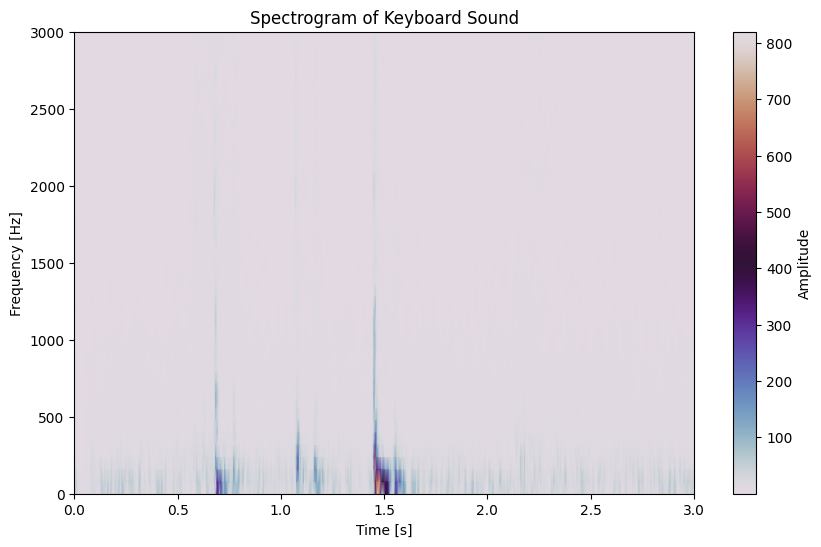

In [61]:
sample_rate, audio_data = wav.read('keyboard_sound.wav')

# Perform STFT
frequencies, times, Zxx = stft(audio_data, fs=sample_rate, nperseg=512)

# Plot the spectrogram (magnitude) with an infrared-style colormap
plt.figure(figsize=(10, 6))
plt.pcolormesh(times, frequencies, np.abs(Zxx), shading='gouraud', cmap='twilight')  # Use

#https://matplotlib.org/stable/users/explain/colors/colormaps.html

# using cyclic colormaps for high contrast
plt.title('Spectrogram of Keyboard Sound')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.colorbar(label='Amplitude')

# Set axis limits
plt.xlim(0, np.max(times))
plt.ylim(0, duration*1000)

# Increase contrast by using logarithmic scaling
#plt.yscale('log')  # Optional: Log scale can highlight more details
plt.show()


## The tricky part : applying a threshold based on ENERGY and FREQUENCY

performing the fast Fourier transform on the recording and summing the coefficients across frequencies to get ‘energy’. An energy threshold is then defined and used to signify thepresence of a keystroke

In [62]:
# Load the recorded audio
sample_rate, audio_data = wav.read('keyboard_sound.wav')

# Convert stereo to mono if necessary
if len(audio_data.shape) > 1:
    audio_data = np.mean(audio_data, axis=1)

# Apply a bandpass filter around 2000 Hz to isolate keystroke frequencies
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Filter the signal around the keystroke frequency range (e.g., 1800-2200 Hz)
filtered_audio = bandpass_filter(audio_data, 1000, 2500, sample_rate)

# Compute the STFT
frequencies, times, Zxx = stft(filtered_audio, fs=sample_rate, nperseg=1024)

# Find the index of the 2000 Hz band in the STFT
freq_idx = np.argmin(np.abs(frequencies - 2000))

# Extract the energy at the 2000 Hz frequency band
keystroke_energy = np.abs(Zxx[freq_idx, :])

# Find peaks in the energy signal to detect keystroke moments
peaks, _ = find_peaks(keystroke_energy, height=np.max(keystroke_energy) * 0.5, distance=10)

# Convert peak indices to actual time values
keystroke_times = times[peaks]

print("Detected keystroke times (seconds):", keystroke_times)


Detected keystroke times (seconds): [0.68515815 1.0713382  1.45751825]


In [65]:
import scipy.signal as signal
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft

# Create directory to save spectrograms
output_dir = "keystroke_spectrograms"
os.makedirs(output_dir, exist_ok=True)

# For each detected keystroke time, extract the audio segment and generate a spectrogram
for idx, keystroke_time in enumerate(keystroke_times):
    # Convert keystroke time from seconds to sample index
    start_sample = max(0, int(keystroke_time * sample_rate - 0.1 * sample_rate))
    end_sample = min(len(audio_data), int(keystroke_time * sample_rate + 0.1 * sample_rate))

    print(f"Keystroke {idx + 1}: Start {start_sample}, End {end_sample}")  # Debugging print

    # Extract the audio segment for this keystroke
    keystroke_audio = audio_data[start_sample:end_sample]

    # Apply STFT to extract the spectrogram for this keystroke
    _, _, Zxx_keystroke = stft(keystroke_audio, fs=sample_rate, nperseg=1024)

    # Save the spectrogram as an image
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(np.abs(Zxx_keystroke), shading='auto', cmap='inferno')  # Use infrared-like colors
    plt.title(f'Keystroke Spectrogram {idx + 1}')
    plt.xlabel('Time [s]')
    plt.ylabel('Frequency [Hz]')
    plt.colorbar(label='Amplitude')

    # Save the figure
    plt.savefig(os.path.join(output_dir, f"keystroke_{idx + 1}.png"))
    plt.close()


Keystroke 1: Start 24050, End 32270
Keystroke 2: Start 39922, End 48142
Keystroke 3: Start 55794, End 64014
